# Predicting Airbnb nightly price from property and host data

**Tomas Beuzen, May 2021**

In [1]:
from src import analysis, plotting
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Summary

Here we attempt to build a regression model, using the k-nearest neighbors algorithm, which uses characteristics of an Airbnb property and host (price, bedrooms, host response rate, etc.) to predict the nightly price of the property. This model could help prospective and exisiting hosts determine how to price their new or existing property.

## The data set

### Introduction to the data

The data we will be using to build our model contains all the active Airbnb listings for Vancouver, Canada. The data set comes from [Inside Airbnb](http://insideairbnb.com/) and is updated monthly - we'll be using the most recent version of the data from April 2021.

The data set comprises 74 features. We'll be loading only a subset of features we believe to be relevant for this analysis, but more detailed EDA and evaluation could be used to determine exactly which of those 74 features would be useful in our model. The features we'll be looking at are:

- The host response rate (`host_response_rate`);
- The host acceptance rate (`host_acceptance_rate`);
- The property location (`latitude` and `longitude`);
- Number of bedrooms, number of beds, and number of guests the property accommodates (`bedrooms`, `beds` and `accommodates`);
- The minimum number of nights a guests must stay (`minimum_nights`); and,
- The review score of the property and number of reviews (`review_scores_rating`).

The target variable we wish to predict is the property's nightly price (`price`). This is a number greater than 0.

### Loading the data

The data set on [Inside Airbnb](http://insideairbnb.com/) is available at the URL below. We'll be reading it in with the Pandas function `pd.read_csv()`. We'll load the subset of the data we're interested in using the argument `usecols`. Note also that the data is is a zipped file (.gz extension), so we need to specify the argument `compression="gzip"`.

In [2]:
url = "http://data.insideairbnb.com/canada/bc/vancouver/2021-04-12/data/listings.csv.gz"
data = analysis.load_data(url)

Let's take a quick look at our column data types and how many non-null values they have:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4299 entries, 0 to 4298
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_response_rate    2991 non-null   object 
 1   host_acceptance_rate  3099 non-null   object 
 2   latitude              4299 non-null   float64
 3   longitude             4299 non-null   float64
 4   accommodates          4299 non-null   int64  
 5   bedrooms              3987 non-null   float64
 6   beds                  4263 non-null   float64
 7   price                 4299 non-null   object 
 8   minimum_nights        4299 non-null   int64  
 9   number_of_reviews     4299 non-null   int64  
 10  review_scores_rating  3474 non-null   float64
dtypes: float64(5), int64(3), object(3)
memory usage: 369.6+ KB


Notice that several of our columns have missing values. We can count how many rows have at least one missing values with the following code:

In [4]:
data.isna().any(axis=1).sum()

2180

Let's also take a quick look at some summary statistics of the data:

In [7]:
data.describe()

,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,number_of_reviews,rating
count,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000
mean,94.640520,85.803176,49.263404,-123.111866,3.429740,1.507218,1.791627,132.871030,14.502887,48.244947,94.943215
std,16.197423,22.537045,0.019902,0.038080,1.806643,0.755462,1.021383,80.401009,22.796408,69.014747,7.907606
min,0.000000,0.000000,49.202960,-123.217570,1.000000,1.000000,0.000000,20.000000,1.000000,1.000000,20.000000
25%,100.000000,83.000000,49.250110,-123.128578,2.000000,1.000000,1.000000,79.000000,2.000000,5.000000,94.000000
50%,100.000000,95.000000,49.269220,-123.115675,3.000000,1.000000,2.000000,113.000000,3.000000,22.000000,97.000000
75%,100.000000,100.000000,49.279360,-123.090042,4.000000,2.000000,2.000000,160.000000,30.000000,63.000000,100.000000
max,100.000000,100.000000,49.293830,-123.017390,16.000000,6.000000,9.000000,499.000000,365.000000,641.000000,100.000000


### Pre-processing

We need to do some minor pre-processing to the data before we can build our classification model. We will:
1. Only look at properties with at least 1 `number_of_reviews`;
2. Drop rows with one of more `NaN` entries;
3. Remove the "\%" from the `host_response_rate` and `host_acceptance_rate` columns; and,
4. Remove the "\$" from the `price` column.

There are various ways to accomplish the above tasks. I'll be using regex and the `.replace()` method.

In [6]:
data = analysis.wrangle_data(data)
data.head()

,host_response_rate,host_acceptance_rate,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,number_of_reviews,rating
0,93,87,49.28872,-123.12046,5,2.0,2.0,150.0,90,16,93.0
1,100,57,49.28201,-123.12669,2,1.0,1.0,85.0,30,430,93.0
2,100,78,49.25622,-123.06607,2,1.0,1.0,145.0,30,88,98.0
3,100,0,49.26557,-123.09600,2,1.0,1.0,51.0,30,118,91.0
4,100,100,49.27569,-123.07057,2,1.0,1.0,79.0,1,390,100.0


### Splitting data into training and testing sets

We'll randomly split the data into a train/test split of 80%/20% using the `sklearn` function `train_test_split()`. We'll also set the seed for reproducibility:

In [9]:
test_fraction = 0.2
airbnb_train, airbnb_test = train_test_split(data, test_size=test_fraction, random_state=123)
analysis.train_test_table(airbnb_train, airbnb_test)

,Partition,Fraction,Median price,Mean price,Std price
0,Train,0.8,113.0,132.7,80.7
1,Test,0.2,112.5,133.5,79.5


We can see that some basic summary statistics of the training and testing sets are similar.

## EDA

We want to determine which of our features is important for predicting the response variable `price`. To this end, we'll create scatterplots of each of the features with the response `price` and fit a regression line. We'll be using the `seaborn` library for this, combining the functions `sns.FacetGrid()` and `sns.map()`:

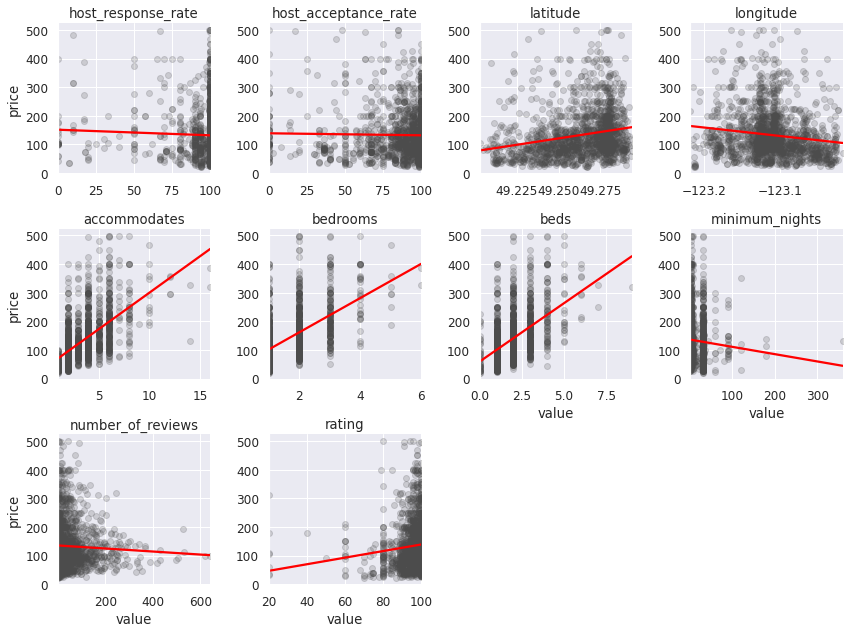

In [11]:
plotting.reg_subplots(airbnb_train)

## Modelling

We will use k-nearest neighbors regression to predict Airbnb nightly prices from our features. To find the best value of the hyperparameter `k` (number of nearest neighbours), we will perform 10-fold cross validation using root-mean-squared-error as our metric of model prediction performance.

Note that our input features are on different scales, e.g., latitude is in degrees and number of bedrooms is an integer. To allow our k-nearest neighbors model to equally weight features, we should scale the data before training. We'll use the `sklearn` function `MinMaxScaler()` to normalize our features to be between 0 and 1.

In [12]:
X_train, y_train, X_test, y_test = analysis.df_to_xy(airbnb_train, airbnb_test, normalize=True)

We'll explore model predictive performance on values of `k` from 1 to 30:

In [13]:
cv_results_df = analysis.k_optimization(X_train, y_train)
cv_results_df.sort_values(by="Mean", ignore_index=True).head(10)

,k,Mean,Min,Max
0,21,58.765872,51.753775,61.677649
1,22,58.809050,52.029350,61.642773
2,20,58.819265,51.978106,61.794625
3,23,58.829717,52.301975,61.529721
4,17,58.872414,52.087746,61.171613
5,19,58.901764,52.047121,61.573112
6,18,58.904485,52.107105,61.419542
7,24,58.952125,52.175803,61.651625
8,16,58.967294,52.094039,61.057476
9,14,59.067362,52.084496,61.504201


We'll use the `altair` library to make a plot of these results:

In [15]:
plotting.cv_results(cv_results_df)

alt.LayerChart(...)

It seems like after about `k=10` there is little change in model predictive performance in terms of RMSE. In the interest of parsimony (choosing a simpler model over a more complex model), we'll opt for `k=10` rather than, say, `k=20` or `k=30`.

## Results

Let's fit our final model:

In [16]:
model = KNeighborsRegressor(n_neighbors=10).fit(X_train, y_train)

Finally, we can get the performance of the model on the withheld test data. Ideally, the performance on the test set will be similar to the performance observed during cross-validation.

In [20]:
print(f"Test RMSE: ${mean_squared_error(y_test, model.predict(X_test), squared=False):.2f}")

Test RMSE: $57.64
